Re-doing SBI with an alternative approach to pre-create the simulation data and separate out the training steps to allow for sampling over both mass and concentration.

In [6]:
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.utils import BoxUniform
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNPE, SNLE, SNRE
from sbi.analysis import pairplot

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import pyccl as ccl
import pyccl.halos.profiles as prof
import pyccl.halos.concentration as conc

In [4]:
cosmo = ccl.core.Cosmology(Omega_c=0.27 - 0.045, Omega_b=0.045, h=0.7, n_s=0.98, 
                     sigma8=0.8, Omega_k=0.0)

## SBI with varying mass, fixed concentration

### gen 10,000 mass-conc points scattered about Diemer-Kravtsov relation:

In [7]:
mdef = ccl.halos.massdef.MassDef(200,'critical')
dkmcrelation = conc.ConcentrationDiemer15(mdef=mdef)
dkmcrelation.get_concentration(cosmo, float(10**15), a=1/(1.2))

3.810924108975283

In [8]:
logmasses = np.linspace(13.7, 14.7, 20)
concentrations = [dkmcrelation.get_concentration(cosmo, 10**logmass, a=1/1.2) \
                  for logmass in logmasses]

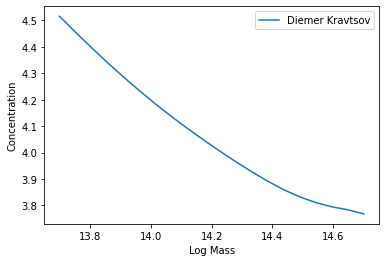

In [9]:
plt.plot(logmasses, concentrations, label='Diemer Kravtsov')
plt.xlabel('Log Mass')
plt.ylabel('Concentration')
plt.legend()

In [30]:
# generate 10,000 random mass points in the range 13.7,14.7
samplesize = 10000
samplemasses = np.random.uniform(low=13.7,high=14.7,size=samplesize)

In [31]:
dkmcrelation.get_concentration(cosmo, 10**np.array([14.3,13.9]), a=1/1.2)

array([3.95051022, 4.29652254])

In [32]:
sampleconcentrations = dkmcrelation.get_concentration(cosmo, 10**samplemasses, a=1/1.2)

In [40]:
noisysampleconcentrations = sampleconcentrations + np.random.normal(0,0.1,samplesize)


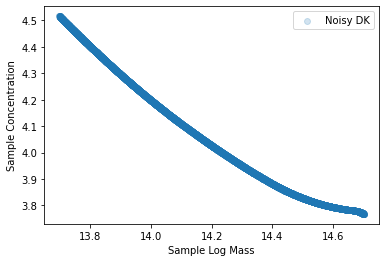

In [41]:
plt.scatter(samplemasses, sampleconcentrations, label='Noisy DK',alpha=0.2)
plt.xlabel('Sample Log Mass')
plt.ylabel('Sample Concentration')
plt.legend()

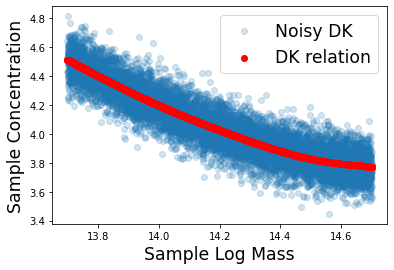

In [59]:
plt.scatter(samplemasses, noisysampleconcentrations, label='Noisy DK',alpha=0.2)
plt.scatter(samplemasses, sampleconcentrations, label ='DK relation', color='red')
plt.xlabel('Sample Log Mass',fontsize='xx-large')
plt.ylabel('Sample Concentration',fontsize='xx-large')
plt.legend(fontsize='xx-large')

In [47]:
# Generate simulated NFW with noisy DK concentration mass relation

In [52]:
mdef = ccl.halos.massdef.MassDef(200,'critical')
a_source = 1.0/(1+1.7)
a_lens = 1.0/(1+0.2)
r = np.logspace(np.log10(0.1),np.log10(0.5), 20)

def simulateConvergenceProfile(logm,concentration):
    nfw = prof.HaloProfileNFW(conc.ConcentrationConstant(c=concentration))
    return nfw.convergence(cosmo, r, 10**logm, a_lens, a_source, mdef)

In [53]:
profiles = simulateConvergenceProfile(samplemasses,noisysampleconcentrations)

In [56]:
np.shape(profiles)

(10000, 20)

In [57]:
np.save('noisy_DK_NFW_profiles.npy', profiles)

### now the simulations are saved for future use -- don't have to re-make these

In [58]:
np.save('noisy_DK_massconc_pairs.npy', 
        np.array([samplemasses,noisysampleconcentrations]))